In [1]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import crystalball
from scipy.optimize import curve_fit,Bounds
from scipy.integrate import simps
import zfit_physics as zphysics
import zfit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import mplhep
import uncertainties 
from uncertainties import ufloat
import tensorflow as tf

plt.style.use('belle2')
#%jsroot on


2024-09-13 08:10:53.776446: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-13 08:10:53.808766: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-13 08:10:53.810182: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 08:10:54.994328: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warnin

In [2]:
file_bkg="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/background/B0eepip4Streams.root"
#file_signal="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/signal/B0eepip200000.root"

file_rec_jpsi="/pnfs/desy.de/belle/local/user/msobotzi/jpsi/afterAcceptance/B0eepip.root"
file_gen_jpsi="/pnfs/desy.de/belle/local/user/msobotzi/jpsi/afterPreCals/MC511_pip.root"

In [3]:
class trimVars():
    def trimCosTheta_L(df, Btree, pi, ll, q2):
        if int(Btree) == 511:
            if q2 == 1:
                df = df.query('abs(cosTheta_L) < 0.75')
            if q2 == 4:
                df = df.query('abs(cosTheta_L) < 0.95')
        
        if int(Btree) == 521:
            if pi == 'pip':
                if q2 == 1:
                    df = df.query('abs(cosTheta_L) < 0.75')
                elif q2 ==4:
                    df = df.query('abs(cosTheta_L) < 0.95')
            if pi =='pi0':
                if q2 == 1:
                    df = df.query('abs(cosTheta_L) < 0.75')
                elif q2 !=4:
                    df = df.query('abs(cosTheta_L) < 0.9')
        return df

    
    def trimCosTheta_K(df, Btree, pi, ll, q2):
        if int(Btree) == 511:
            if q2 == 1:
                df = df.query('cosTheta_K > -0.9')
            elif q2 != 4:
                df = df.query('cosTheta_K > -0.9')
            else:
                df = df.query('abs(cosTheta_K) < 0.95')
                
        if int(Btree) == 521:
            if q2 == 1:
                if pi == 'pip':
                    df = df.query('cosTheta_K > -0.9')
                else:
                    df = df.query('cosTheta_K > 0.9')
            elif q2 != 4:
                if pi == 'pip':
                    df = df.query('cosTheta_K > -0.9')
                elif pi == 'pi0':
                    df = df.query('cosTheta_K > -0.9')
                    
            elif q2 == 4:
                if pi == 'pip':
                    df = df.query('abs(cosTheta_K) > -0.95')
                if pi == 'pi0':
                    df = df.query('abs(cosTheta_K) < 0.9')
        return df
    
    def trimmers(df, Btree, pi, ll, q2):
        df = trimVars.trimCosTheta_L(df, Btree, pi, ll, q2)
        df = trimVars.trimCosTheta_K(df, Btree, pi, ll, q2)
        return df


In [4]:
def process_MC_data_combined_jpsi(file_path_background, Btree, pi, ll, q2,NN,weight_column):
    def process_mc_data(file_path, q2,NN):
        df = uproot.open(f"{file_path}:rec511")
        keylist = df.keys()
        df = df.arrays(library='pd')
        mc_data = trimVars.trimmers(df, Btree, pi, ll, q2)
        if NN:
            mc_cut = mc_data.query('NNPass==1')
            mc_cut_best_candidate = mc_cut.query('bestCandidate == 1')
        else:
            mc_cut_best_candidate = mc_data
        return mc_cut_best_candidate

    mc_cut_best_candidate_background = process_mc_data(file_path_background, q2,NN)
   
    # Apply range cut for deltaE
    deltaE_range = (-0.15, 0.15)

    # Signal
    mc_signal_q2cut_jpsi_kst_wot_filter = mc_cut_best_candidate_background
    mc_signal_q2cut_jpsi_kst = mc_signal_q2cut_jpsi_kst_wot_filter[(mc_signal_q2cut_jpsi_kst_wot_filter['deltaE'] >= deltaE_range[0]) & (mc_signal_q2cut_jpsi_kst_wot_filter['deltaE'] <= deltaE_range[1])]
    mc_only_signal_q2cut_jpsi_kst=mc_signal_q2cut_jpsi_kst.query('isSignal==1')
    mc_scf_q2cut_jpsi_kst=mc_signal_q2cut_jpsi_kst.query('isSignal!=1')

    # Data
    mc_signal_data =mc_signal_q2cut_jpsi_kst
    mc_only_signal_data = mc_only_signal_q2cut_jpsi_kst
    mc_scf_data = mc_scf_q2cut_jpsi_kst
    if NN:
        # Weight
        mc_signal_weight_q2cut_jpsi_kst=mc_signal_q2cut_jpsi_kst["PIDCorrectionAndAcceptanceWeight"]
        mc_only_signal_weight_q2cut_jpsi_kst = mc_only_signal_q2cut_jpsi_kst["PIDCorrectionAndAcceptanceWeight"]
        mc_scf_weight_q2cut_jpsi_kst=mc_scf_q2cut_jpsi_kst["PIDCorrectionAndAcceptanceWeight"]


        # Weight Data
        mc_signal_weight = mc_signal_weight_q2cut_jpsi_kst
        mc_only_signal_weight = mc_only_signal_weight_q2cut_jpsi_kst
        mc_scf_weight = mc_scf_weight_q2cut_jpsi_kst
        
        return mc_signal_data,mc_only_signal_data,mc_scf_data,mc_signal_weight,mc_only_signal_weight,mc_scf_weight

    else:
        return mc_signal_data,mc_only_signal_data,mc_scf_data

mc_ele_rec_accpt_signal,mc_ele_rec_accpt_only_signal,mc_ele_rec_accpt_scf, mc_ele_rec_accpt_signal_weight, mc_ele_rec_accpt_only_signal_weight,mc_ele_rec_accpt_scf_weight = process_MC_data_combined_jpsi(file_rec_jpsi,'511','pip','ee','11',True,"PIDCorrectionAndAcceptanceWeight")

mc_ele_rec_signal,mc_ele_rec_only_signal,mc_ele_rec_scf, mc_ele_rec_signal_weight, mc_ele_rec_only_signal_weight,mc_ele_rec_scf_weight = process_MC_data_combined_jpsi(file_rec_jpsi,'511','pip','ee','11',True,"weights")

mc_ele_gen_signal,mc_ele_gen_only_signal,mc_ele_gen_scf, = process_MC_data_combined_jpsi(file_gen_jpsi,'511','pip','ee','11',False)


/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/uproot/interpretation/library.py:806: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]


TypeError: process_MC_data_combined_jpsi() missing 1 required positional argument: 'weight_column'

In [5]:
def process_MC_data_combined_jpsi(file_path_background, Btree, pi, ll, q2, NN, weight_column=None):
    def process_mc_data(file_path, q2, NN):
        df = uproot.open(f"{file_path}:rec511")
        keylist = df.keys()
        mc_data= df.arrays(library='pd')
        #mc_data = trimVars.trimmers(df, Btree, pi, ll, q2)
        if NN:
            mc_cut = mc_data.query('NNPass==1')
            mc_cut_best_candidate = mc_cut.query('bestCandidate == 1')
        else:
            mc_cut_best_candidate = mc_data
        return mc_cut_best_candidate

    mc_cut_best_candidate_background = process_mc_data(file_path_background, q2, NN)
   
    # Apply range cut for deltaE
    deltaE_range = (-0.15, 0.15)

    # Signal
    mc_signal_q2cut_jpsi_kst_wot_filter = mc_cut_best_candidate_background
    mc_signal_q2cut_jpsi_kst = mc_signal_q2cut_jpsi_kst_wot_filter[(mc_signal_q2cut_jpsi_kst_wot_filter['deltaE'] >= deltaE_range[0]) & (mc_signal_q2cut_jpsi_kst_wot_filter['deltaE'] <= deltaE_range[1])]
    mc_only_signal_q2cut_jpsi_kst = mc_signal_q2cut_jpsi_kst.query('isSignal==1')
    mc_scf_q2cut_jpsi_kst = mc_signal_q2cut_jpsi_kst.query('isSignal!=1')

    # Data
    mc_signal_data = mc_signal_q2cut_jpsi_kst
    mc_only_signal_data = mc_only_signal_q2cut_jpsi_kst
    mc_scf_data = mc_scf_q2cut_jpsi_kst

    if NN:
        # Weight
        mc_signal_weight_q2cut_jpsi_kst = mc_signal_q2cut_jpsi_kst[weight_column]
        mc_only_signal_weight_q2cut_jpsi_kst = mc_only_signal_q2cut_jpsi_kst[weight_column]
        mc_scf_weight_q2cut_jpsi_kst = mc_scf_q2cut_jpsi_kst[weight_column]

        # Weight Data
        mc_signal_weight = mc_signal_weight_q2cut_jpsi_kst
        mc_only_signal_weight = mc_only_signal_weight_q2cut_jpsi_kst
        mc_scf_weight = mc_scf_weight_q2cut_jpsi_kst
        
        return mc_signal_data, mc_only_signal_data, mc_scf_data, mc_signal_weight, mc_only_signal_weight, mc_scf_weight
    else:
        return mc_signal_data, mc_only_signal_data, mc_scf_data

# Function calls
mc_ele_rec_accpt_signal, mc_ele_rec_accpt_only_signal, mc_ele_rec_accpt_scf, mc_ele_rec_accpt_signal_weight, mc_ele_rec_accpt_only_signal_weight, mc_ele_rec_accpt_scf_weight = process_MC_data_combined_jpsi(file_rec_jpsi, '511', 'pip', 'ee', '11', True, "PIDCorrectionAndAcceptanceWeight")

mc_ele_rec_signal, mc_ele_rec_only_signal, mc_ele_rec_scf, mc_ele_rec_signal_weight, mc_ele_rec_only_signal_weight, mc_ele_rec_scf_weight = process_MC_data_combined_jpsi(file_rec_jpsi, '511', 'pip', 'ee', '11', True, "weights")

# No weight_column argument needed when NN is False
mc_ele_gen_signal, mc_ele_gen_only_signal, mc_ele_gen_scf = process_MC_data_combined_jpsi(file_gen_jpsi, '511', 'pip', 'ee', '11', False)


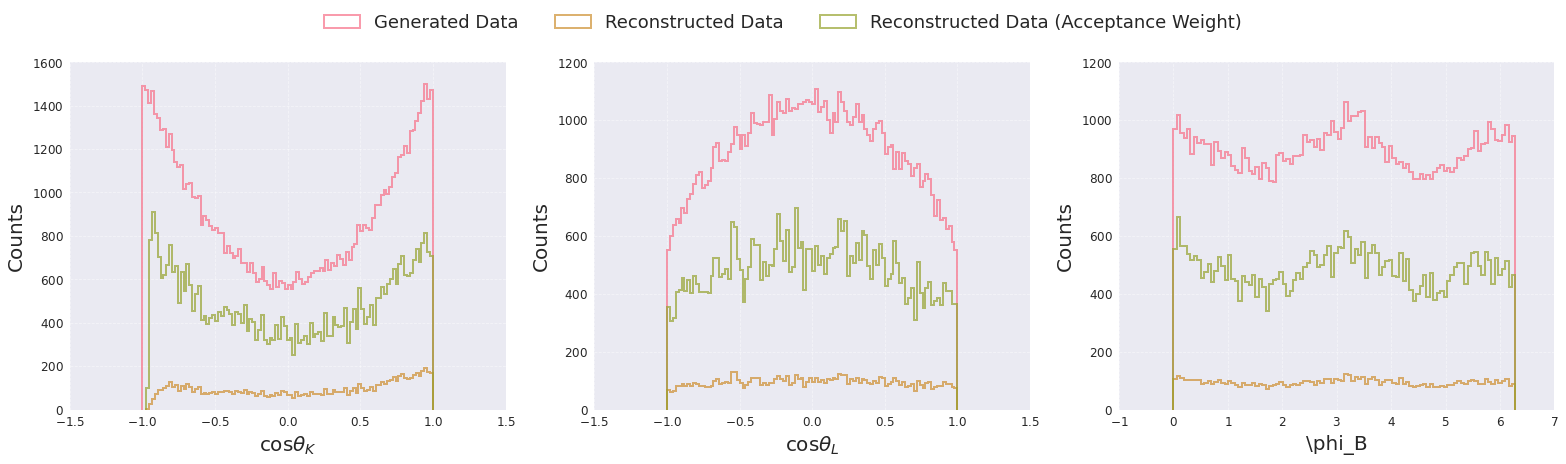

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the improved plot function
def plot_histogram(ax, bins, data_dict, labels, xlabel, ylabel, weights=None, color=None):
    if weights is None:
        ax.hist(data_dict, bins=bins, alpha=0.7, label=labels, histtype='step', linewidth=2, color=color)
    else:
        ax.hist(data_dict, bins=bins, weights=weights, alpha=0.7, label=labels, histtype='step', linewidth=2, color=color)
    
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(axis='both', which='major', labelsize=12)

# Create a figure with subplots in one row (1 row, 3 columns)
plt.style.use('seaborn-darkgrid')
fig, axs = plt.subplots(1, 3, figsize=(22, 6))  # One row, 3 columns

# Define a color palette
colors = sns.color_palette("husl", 8)

# Plot each histogram with labels and weights, using different colors for gen, rec, and acceptance data
plot_histogram(axs[0], 100, mc_ele_gen_only_signal["cosTheta_K"], "Generated Data", 'cos$\\theta_K$', 'Counts', color=colors[0])
plot_histogram(axs[1], 100, mc_ele_gen_only_signal["cosTheta_L"], "Generated Data", 'cos$\\theta_L$', 'Counts', color=colors[0])
plot_histogram(axs[2], 100, mc_ele_gen_only_signal["phi_B"], "Generated Data", 'phi_B', 'Counts', color=colors[0])

plot_histogram(axs[0], 100, mc_ele_rec_only_signal["cosTheta_K"], "Reconstructed Data", 'cos$\\theta_K$', 'Counts', weights=mc_ele_rec_only_signal_weight, color=colors[1])
plot_histogram(axs[1], 100, mc_ele_rec_only_signal["cosTheta_L"], "Reconstructed Data", 'cos$\\theta_L$', 'Counts', weights=mc_ele_rec_only_signal_weight, color=colors[1])
plot_histogram(axs[2], 100, mc_ele_rec_only_signal["phi_B"], "Reconstructed Data", '\\phi_B', 'Counts', weights=mc_ele_rec_only_signal_weight, color=colors[1])

plot_histogram(axs[0], 100, mc_ele_rec_accpt_only_signal["cosTheta_K"], "Reconstructed Data (Acceptance Weight)", 'cos$\\theta_K$', 'Counts', weights=mc_ele_rec_accpt_only_signal_weight, color=colors[2])
plot_histogram(axs[1], 100, mc_ele_rec_accpt_only_signal["cosTheta_L"], "Reconstructed Data (Acceptance Weight)", 'cos$\\theta_L$', 'Counts', weights=mc_ele_rec_accpt_only_signal_weight, color=colors[2])
plot_histogram(axs[2], 100, mc_ele_rec_accpt_only_signal["phi_B"], "Reconstructed Data (Acceptance Weight)", '\\phi_B', 'Counts', weights=mc_ele_rec_accpt_only_signal_weight, color=colors[2])

# Collect handles and labels from each subplot
handles, labels = [], []
for ax in axs:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        if label not in labels:  # Avoid duplicates
            handles.append(handle)
            labels.append(label)

# Place the legend outside the plot with larger fontsize
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, fontsize=18)

# Adjust layout to avoid overlap
plt.tight_layout()

# Save the figure with the legend included (using bbox_inches='tight')
plt.savefig("Weight_effect.pdf", format="pdf", bbox_inches='tight')

# Display the figure
plt.show()




In [10]:
def process_MC_data_combined_jpsi_wo_klcut(file_path_jpsi,NN,particle_type,weight_column):
    def process_mc_data(file_path,NN):
        mc_data = uproot.open(f"{file_path}:rec511")
        keylist = mc_data.keys()
        mc = mc_data.arrays(keylist, library='pd')
        if NN:
            mc_cut = mc.query('NNPass==1')
            mc_cut_best_candidate = mc_cut.query('bestCandidate == 1')
        else:
            mc_cut_best_candidate = mc  
        return mc_cut_best_candidate
    
    mc_cut_best_candidate_background = process_mc_data(file_path_jpsi,NN)
   
    # Apply range cut for deltaE
    deltaE_range = (-0.15, 0.15)

    # Signal
    mc_signal_q2cut_jpsi_kst_wot_filter = mc_cut_best_candidate_background
    mc_signal_q2cut_jpsi_kst = mc_signal_q2cut_jpsi_kst_wot_filter[(mc_signal_q2cut_jpsi_kst_wot_filter['deltaE'] >= deltaE_range[0]) & (mc_signal_q2cut_jpsi_kst_wot_filter['deltaE'] <= deltaE_range[1])]
    mc_only_signal_q2cut_jpsi_kst=mc_signal_q2cut_jpsi_kst.query('isSignal==1')
    mc_scf_q2cut_jpsi_kst=mc_signal_q2cut_jpsi_kst.query('isSignal!=1')

    # Data
    mc_signal_data =mc_signal_q2cut_jpsi_kst
    mc_only_signal_data = mc_only_signal_q2cut_jpsi_kst
    mc_scf_data = mc_scf_q2cut_jpsi_kst
    
    if NN:
        # Weight
        mc_signal_weight_q2cut_jpsi_kst=mc_signal_q2cut_jpsi_kst[weight_column]
        mc_only_signal_weight_q2cut_jpsi_kst = mc_only_signal_q2cut_jpsi_kst[weight_column]
        mc_scf_weight_q2cut_jpsi_kst=mc_scf_q2cut_jpsi_kst["PIDCorrectionAndAcceptanceWeight"]


        # Weight Data
        mc_signal_weight = mc_signal_weight_q2cut_jpsi_kst
        mc_only_signal_weight = mc_only_signal_weight_q2cut_jpsi_kst
        mc_scf_weight = mc_scf_weight_q2cut_jpsi_kst
        
        return mc_signal_data,mc_only_signal_data,mc_scf_data,mc_signal_weight,mc_only_signal_weight,mc_scf_weight

    else:
        return mc_signal_data,mc_only_signal_data,mc_scf_data
    

q2reg_value = 11

mc_ele_rec_accpt_signal_wo_klcut,mc_ele_rec_accpt_only_signal_wo_klcut,mc_ele_rec_accpt_scf_wo_klcut, mc_ele_rec_accpt_signal_weight_wo_klcut, mc_ele_rec_accpt_only_signal_weight_wo_klcut,mc_ele_rec_accpt_scf_weight_wo_klcut = process_MC_data_combined_jpsi_wo_klcut(file_rec_jpsi,True,"ele","PIDCorrectionAndAcceptanceWeight")

mc_ele_gen_signal_wo_klcut,mc_ele_gen_only_signal_wo_klcut,mc_ele_gen_scf_wo_klcut = process_MC_data_combined_jpsi_wo_klcut(file_gen_jpsi,False,"ele")

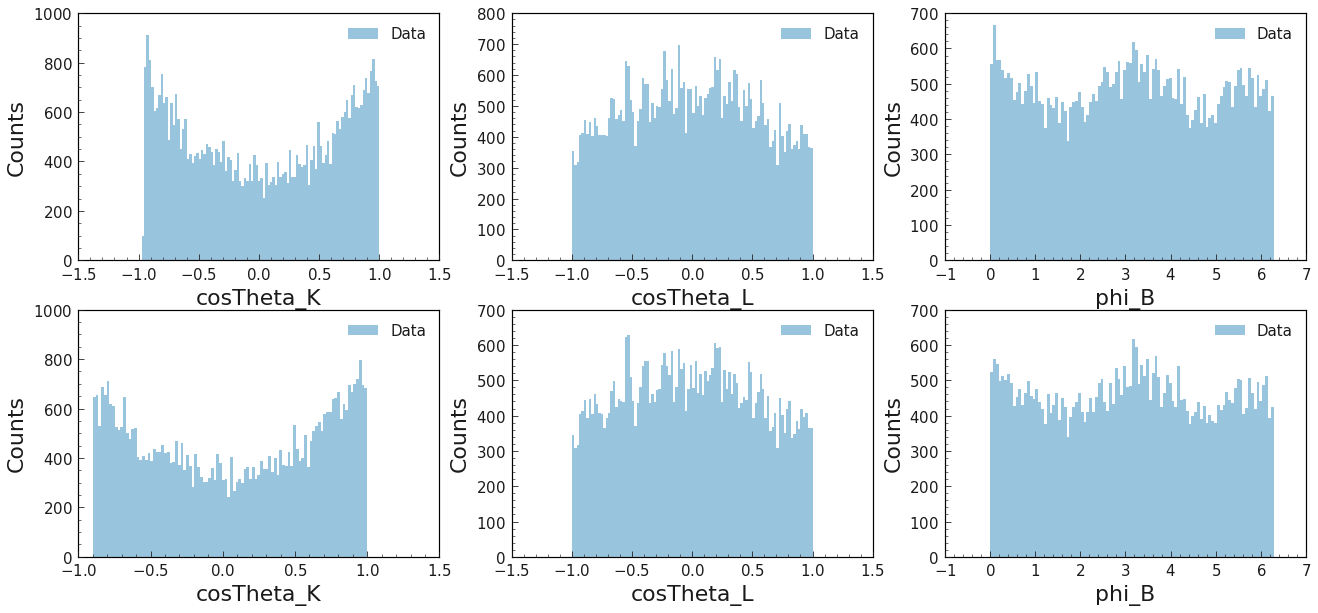

In [13]:
def plot_histogram(ax, bins, data_dict, labels, xlabel, ylabel, weights=None):
    if weights is None:
        ax.hist(data_dict, bins=bins, alpha=0.5, label=labels)
    else:
        ax.hist(data_dict, bins=bins, weights=weights, alpha=0.5, label=labels)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

# Create a figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(22, 10))

plot_histogram(axs[0, 0], 100, mc_ele_rec_accpt_only_signal_wo_klcut["cosTheta_K"], "Data", 'cosTheta_K', 'Counts', weights=mc_ele_rec_accpt_only_signal_weight_wo_klcut)

plot_histogram(axs[0, 1], 100, mc_ele_rec_only_signal_wo_klcut["cosTheta_L"], "Data", 'cosTheta_L', 'Counts', weights=mc_ele_rec_only_signal_weight_wo_klcut)

plot_histogram(axs[0, 2], 100, mc_ele_rec_only_signal_wo_klcut["phi_B"], "Data", 'phi_B', 'Counts', weights=mc_ele_rec_only_signal_weight_wo_klcut)

plot_histogram(axs[1, 0], 100, mc_ele_rec_only_signal["cosTheta_K"], "Data", 'cosTheta_K', 'Counts', weights=mc_ele_rec_only_signal_weight)

plot_histogram(axs[1, 1], 100, mc_ele_rec_only_signal["cosTheta_L"], "Data", 'cosTheta_L', 'Counts', weights=mc_ele_rec_only_signal_weight)

plot_histogram(axs[1, 2], 100, mc_ele_rec_only_signal["phi_B"], "Data", 'phi_B', 'Counts', weights=mc_ele_rec_only_signal_weight)


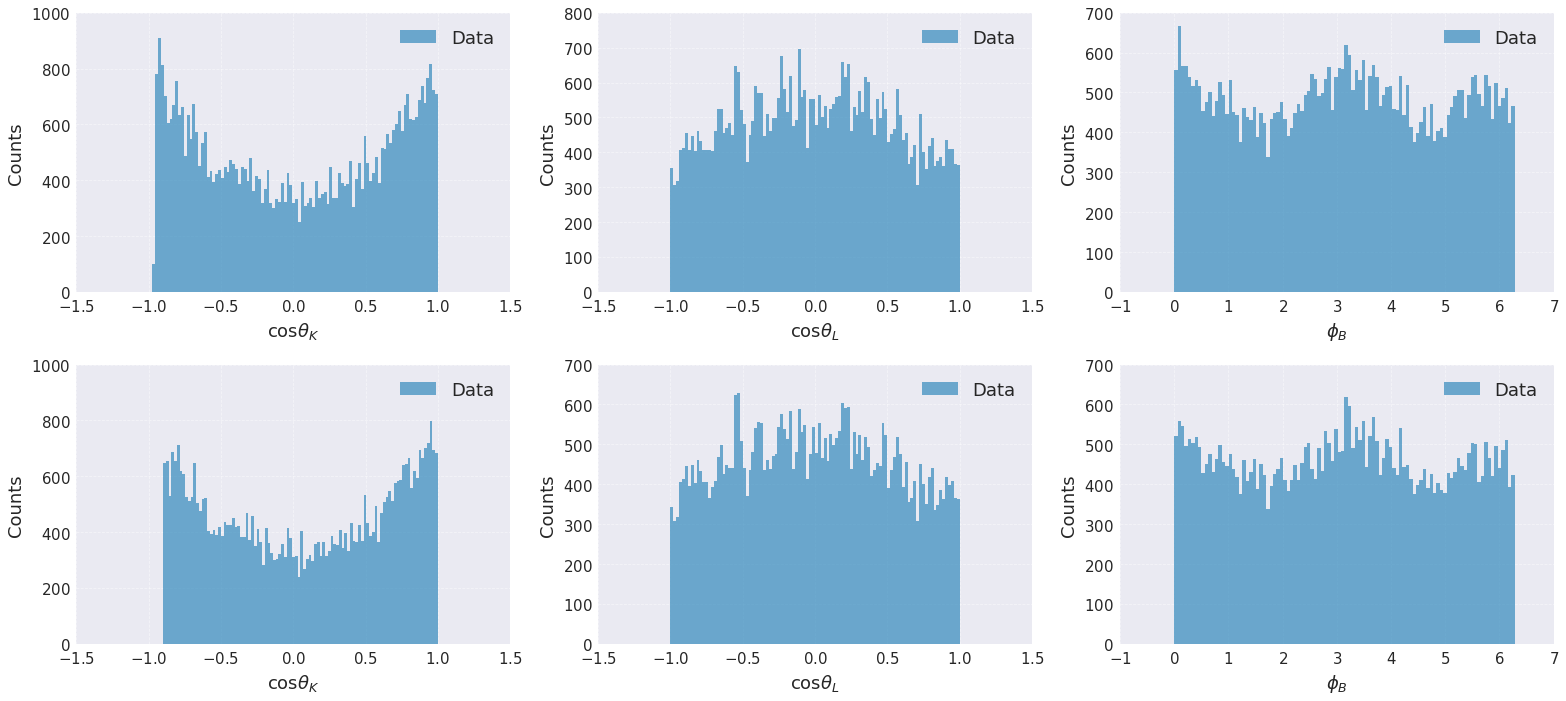

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the improved plot function
def plot_histogram(ax, bins, data_dict, labels, xlabel, ylabel, weights=None):
    if weights is None:
        ax.hist(data_dict, bins=bins, alpha=0.7, label=labels)
    else:
        ax.hist(data_dict, bins=bins, weights=weights, alpha=0.7, label=labels)
    
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='best', fontsize=18)

# Create a figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(22, 10))

# Plot each histogram with labels and weights
plot_histogram(axs[0, 0], 100, mc_ele_rec_only_signal_wo_klcut["cosTheta_K"], "Data", 'cos$\\theta_K$', 'Counts', weights=mc_ele_rec_only_signal_weight_wo_klcut)
plot_histogram(axs[0, 1], 100, mc_ele_rec_only_signal_wo_klcut["cosTheta_L"], "Data", 'cos$\\theta_L$', 'Counts', weights=mc_ele_rec_only_signal_weight_wo_klcut)
plot_histogram(axs[0, 2], 100, mc_ele_rec_only_signal_wo_klcut["phi_B"], "Data", '$\\phi_B$', 'Counts', weights=mc_ele_rec_only_signal_weight_wo_klcut)
plot_histogram(axs[1, 0], 100, mc_ele_rec_only_signal["cosTheta_K"], "Data", 'cos$\\theta_K$', 'Counts', weights=mc_ele_rec_only_signal_weight)
plot_histogram(axs[1, 1], 100, mc_ele_rec_only_signal["cosTheta_L"], "Data", 'cos$\\theta_L$', 'Counts', weights=mc_ele_rec_only_signal_weight)
plot_histogram(axs[1, 2], 100, mc_ele_rec_only_signal["phi_B"], "Data", '$\\phi_B$', 'Counts', weights=mc_ele_rec_only_signal_weight)

# Now set the x-axis limits for axs[0, 0] after plotting
axs[1, 0].set_xlim([-1.5, 1.5])

# Force the limits to stick by disabling autoscale
#axs[0, 0].autoscale(False)

# Adjust layout to avoid overlap and save the plot
plt.tight_layout()
plt.savefig("Timmer_effect.pdf", format="pdf")
plt.show()




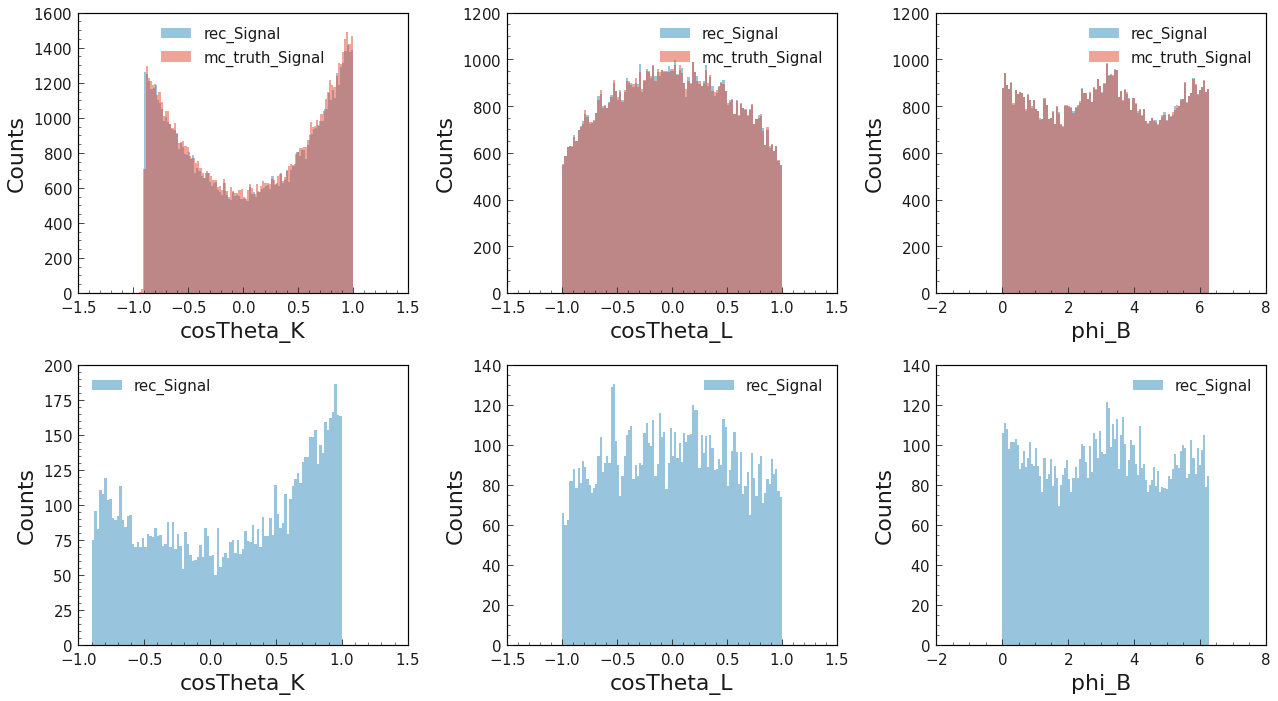

In [6]:
def plot_histogram(ax, bins, data_dict, labels, xlabel, ylabel, weights=None):
    if weights is None:
        ax.hist(data_dict, bins=bins, alpha=0.5, label=labels)
    else:
        ax.hist(data_dict, bins=bins, weights=weights, alpha=0.5, label=labels)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

# Create a figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

plot_histogram(axs[0, 0], 100, mc_ele_gen_only_signal["cosTheta_K"], "rec_Signal", 'cosTheta_K', 'Counts')

plot_histogram(axs[0, 1], 100, mc_ele_gen_only_signal["cosTheta_L"], "rec_Signal", 'cosTheta_L', 'Counts')

plot_histogram(axs[0, 2], 100, mc_ele_gen_only_signal["phi_B"], "rec_Signal", 'phi_B', 'Counts')

plot_histogram(axs[0, 0], 100, mc_ele_gen_only_signal["cosTheta_K_mc"], "mc_truth_Signal", 'cosTheta_K', 'Counts')

plot_histogram(axs[0, 1], 100, mc_ele_gen_only_signal["cosTheta_L_mc"], "mc_truth_Signal", 'cosTheta_L', 'Counts')

plot_histogram(axs[0, 2], 100, mc_ele_gen_only_signal["phi_B_mc"], "mc_truth_Signal", 'phi_B', 'Counts')


plot_histogram(axs[1, 0], 100, mc_ele_rec_only_signal["cosTheta_K"], "rec_Signal", 'cosTheta_K', 'Counts', weights=mc_ele_rec_only_signal_weight)

plot_histogram(axs[1, 1], 100, mc_ele_rec_only_signal["cosTheta_L"], "rec_Signal", 'cosTheta_L', 'Counts', weights=mc_ele_rec_only_signal_weight)

plot_histogram(axs[1, 2], 100, mc_ele_rec_only_signal["phi_B"], "rec_Signal", 'phi_B', 'Counts', weights=mc_ele_rec_only_signal_weight)

#plot_histogram(axs[1, 0], 100, mc_ele_rec_only_signal["cosTheta_K_mc"], "mc_truth_Signal", 'cosTheta_K', 'Counts', weights=mc_ele_rec_only_signal_weight)

#plot_histogram(axs[1, 1], 100, mc_ele_rec_only_signal["cosTheta_L_mc"], "mc_truth_Signal", 'cosTheta_L', 'Counts', weights=mc_ele_rec_only_signal_weight)

#plot_histogram(axs[1, 2], 100, mc_ele_rec_only_signal["phi_B_mc"], "mc_truth_Signal", 'phi_B', 'Counts', weights=mc_ele_rec_only_signal_weight)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()





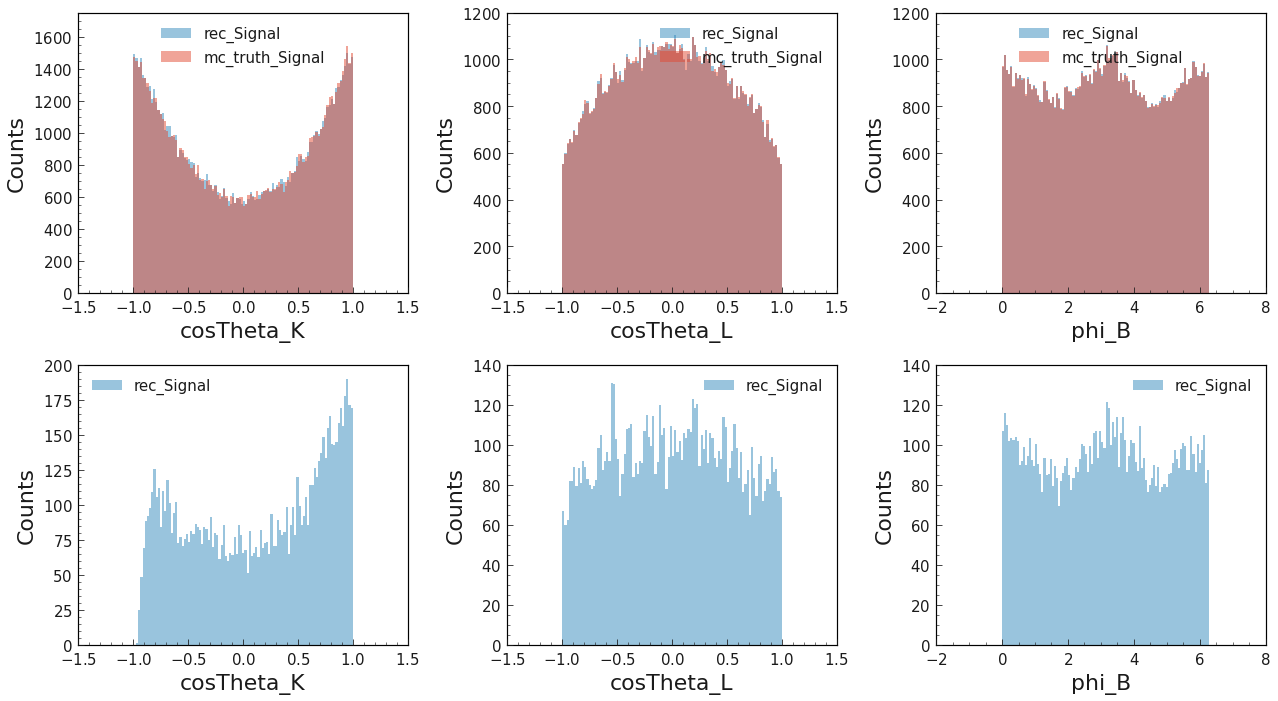

In [7]:
def plot_histogram(ax, bins, data_dict, labels, xlabel, ylabel, weights=None):
    if weights is None:
        ax.hist(data_dict, bins=bins, alpha=0.5, label=labels)
    else:
        ax.hist(data_dict, bins=bins, weights=weights, alpha=0.5, label=labels)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

# Create a figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

plot_histogram(axs[0, 0], 100, mc_ele_gen_only_signal_wo_klcut["cosTheta_K"], "rec_Signal", 'cosTheta_K', 'Counts')

plot_histogram(axs[0, 1], 100, mc_ele_gen_only_signal_wo_klcut["cosTheta_L"], "rec_Signal", 'cosTheta_L', 'Counts')

plot_histogram(axs[0, 2], 100, mc_ele_gen_only_signal_wo_klcut["phi_B"], "rec_Signal", 'phi_B', 'Counts')

plot_histogram(axs[0, 0], 100, mc_ele_gen_only_signal_wo_klcut["cosTheta_K_mc"], "mc_truth_Signal", 'cosTheta_K', 'Counts')

plot_histogram(axs[0, 1], 100, mc_ele_gen_only_signal_wo_klcut["cosTheta_L_mc"], "mc_truth_Signal", 'cosTheta_L', 'Counts')

plot_histogram(axs[0, 2], 100, mc_ele_gen_only_signal_wo_klcut["phi_B_mc"], "mc_truth_Signal", 'phi_B', 'Counts')


plot_histogram(axs[1, 0], 100, mc_ele_rec_only_signal_wo_klcut["cosTheta_K"], "rec_Signal", 'cosTheta_K', 'Counts', weights=mc_ele_rec_only_signal_weight_wo_klcut)

plot_histogram(axs[1, 1], 100, mc_ele_rec_only_signal_wo_klcut["cosTheta_L"], "rec_Signal", 'cosTheta_L', 'Counts', weights=mc_ele_rec_only_signal_weight_wo_klcut)

plot_histogram(axs[1, 2], 100, mc_ele_rec_only_signal_wo_klcut["phi_B"], "rec_Signal", 'phi_B', 'Counts', weights=mc_ele_rec_only_signal_weight_wo_klcut)

#plot_histogram(axs[1, 0], 100, mc_ele_rec_only_signal_wo_klcut["cosTheta_K_mc"], "mc_truth_Signal", 'cosTheta_K', 'Counts', weights=mc_ele_rec_only_signal_weight_wo_klcut)

#plot_histogram(axs[1, 1], 100, mc_ele_rec_only_signal_wo_klcut["cosTheta_L_mc"], "mc_truth_Signal", 'cosTheta_L', 'Counts', weights=mc_ele_rec_only_signal_weight_wo_klcut)

#plot_histogram(axs[1, 2], 100, mc_ele_rec_only_signal_wo_klcut["phi_B_mc"], "mc_truth_Signal", 'phi_B', 'Counts', weights=mc_ele_rec_only_signal_weight_wo_klcut)


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


## With Weight

In [8]:
import zfit
import tensorflow as tf
import pandas as pd
import numpy as np

class p5_prime_pdf(zfit.pdf.ZPDF):
    _N_OBS = 3  # dimension, can be omitted
    _PARAMS = ['param_fl','param_s3','param_p5']  # the name of the parameters

    def _unnormalized_pdf(self, x):
        x, y, z = x.unstack_x()  # x=costk, y=costl, z=phib
        param_fl = self.params['param_fl']
        param_s3 = self.params['param_s3']
        param_p5 = self.params['param_p5']
        
        return (9/(8*np.pi))*((3/4)*(1-param_fl)* (1-x**2) + param_fl * x**2 + \
               (1/4) *(1 - param_fl)* (1-x**2)* (2 * y**2 - 1)- \
               param_fl * x**2 * (2 * y**2 - 1) + param_s3 *(1-x**2)*(1-y**2) * tf.cos(2*z)+ \
               tf.sqrt(param_fl*(1-param_fl)) * param_p5 * 2*tf.sqrt(1-x**2) *x * tf.sqrt(1-y**2)* tf.cos(z))

def p5p_3D_fit(cost_k_data, cost_l_data, phi_b_data, param_fl_start, param_s3_start, param_p5_start, weight, floating=True):
    # create space
    obs_cost_k = zfit.Space('cosTheta_K', limits=(min(cost_k_data), max(cost_k_data)))
    obs_cost_l = zfit.Space('cosTheta_L', limits=(min(cost_l_data), max(cost_l_data)))
    obs_phi_b = zfit.Space('phi_B', limits=(0, np.pi))
    obs = obs_cost_k * obs_cost_l * obs_phi_b

    # data
    df_sig = pd.concat([cost_k_data, cost_l_data, phi_b_data], axis=1)
    df_sig.columns = ['cosTheta_K', 'cosTheta_L', 'phi_B']  # Renaming columns to match observables
    data_fit_sig = zfit.Data.from_pandas(df_sig, obs=obs, weights=weight)

    # parameter variable
    r = np.round(np.random.rand(), decimals=8)

    # parameters
    param_fl = zfit.Parameter(f'param_fl_{r}', param_fl_start, floating=floating)
    param_s3 = zfit.Parameter(f'param_s3_{r}', param_s3_start, floating=floating)
    param_p5 = zfit.Parameter(f'param_p5_{r}', param_p5_start, floating=floating)

    extended = zfit.Parameter(f"extended_{r}", 10000)

    pdf_3D = p5_prime_pdf(param_fl=param_fl, param_s3=param_s3, param_p5=param_p5, obs=obs, extended=extended)
    pdf_3D.update_integration_options(max_draws=10000, tol=1e-4)  # Adjust parameters as needed

    # create NLL
    nll = zfit.loss.ExtendedUnbinnedNLL(model=pdf_3D, data=data_fit_sig)
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)

    if floating == True:
        result.hesse(name='hesse')

    print(result.params)
    print("Fit result valid:")
    print(result.valid)

    return pdf_3D

def fold_data(data):
    data['cosTheta_L'] = data['cosTheta_L'].abs()
    phi_b_gr = data.query(f"phi_B > {np.pi}")
    phi_b_gr['phi_B'] = 2 * np.pi - phi_b_gr['phi_B']
    phi_b_kl = data.query(f"phi_B <= {np.pi}")
    folded_data = pd.concat([phi_b_kl, phi_b_gr])
    return folded_data

mc_ele_only_signal_fold = fold_data(mc_ele_rec_only_signal)
mc_ele_only_signal_wo_klcut_fold = fold_data(mc_ele_rec_only_signal_wo_klcut)

mc_ele_only_signal_weight_fold = mc_ele_only_signal_fold["weights"]
mc_ele_only_signal_weight_wo_klcut_fold = mc_ele_only_signal_wo_klcut_fold["weights"]

# Example usage with adjusted starting parameters
param_fl_start = 0.5  # Adjust based on your data
param_s3_start = 0.01  # Adjust based on your data
param_p5_start = 0.02  # Adjust based on your data

# Reconstructed signal events
print("Reconstructed Signal Events:")
pdf_fit_signal_gr = p5p_3D_fit(mc_ele_only_signal_fold["cosTheta_K"], mc_ele_only_signal_fold["cosTheta_L"], mc_ele_only_signal_fold["phi_B"],
                               param_fl_start, param_s3_start, param_p5_start, weight=mc_ele_only_signal_weight_fold, floating=True)
pdf_fit_signal_kl = p5p_3D_fit(mc_ele_only_signal_wo_klcut_fold["cosTheta_K"], mc_ele_only_signal_wo_klcut_fold["cosTheta_L"], mc_ele_only_signal_wo_klcut_fold["phi_B"],
                               param_fl_start, param_s3_start, param_p5_start, weight=mc_ele_only_signal_weight_wo_klcut_fold, floating=True)

# Calculate total signal events
mc_ele_only_signal_MC_data = sum(mc_ele_only_signal_weight_fold)
mc_ele_only_signal_MC_data_wo_klcut = sum(mc_ele_only_signal_weight_wo_klcut_fold)

print("Signal Events in MC Data =", mc_ele_only_signal_MC_data)
print("Signal Events in MC Data_wo_klcut =", mc_ele_only_signal_MC_data_wo_klcut)



<ipython-input-8-91caff870389>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cosTheta_L'] = data['cosTheta_L'].abs()
<ipython-input-8-91caff870389>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phi_b_gr['phi_B'] = 2 * np.pi - phi_b_gr['phi_B']


Reconstructed Signal Events:
name                   value  (rounded)        hesse    at limit
-------------------  ------------------  -----------  ----------
extended_0.91743036             9229.34  +/- 1.4e-06       False
param_fl_0.91743036             0.53908  +/-  0.0075       False
param_s3_0.91743036           0.0818152  +/-    0.01       False
param_p5_0.91743036          0.00707809  +/-   0.023       False
Fit result valid:
True
name                   value  (rounded)        hesse    at limit
-------------------  ------------------  -----------  ----------
extended_0.03930231              9358.1  +/- 1.3e-06       False
param_fl_0.03930231            0.498434  +/-  0.0075       False
param_s3_0.03930231           0.0866827  +/-   0.011       False
param_p5_0.03930231          0.00466143  +/-   0.022       False
Fit result valid:
True
Signal Events in MC Data = 9230.40543877502
Signal Events in MC Data_wo_klcut = 9357.987978410029


Total number of events: 9232.401501528238


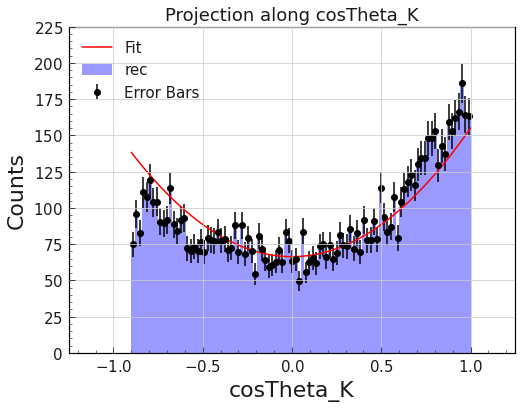

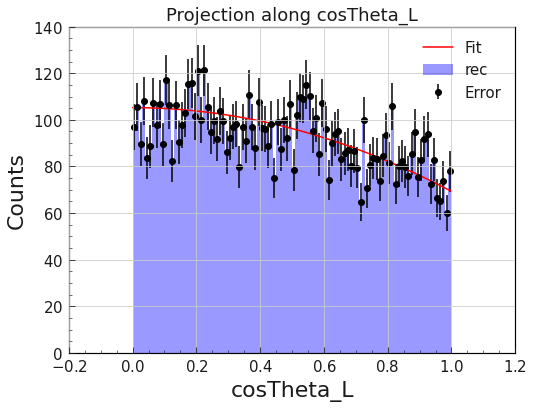

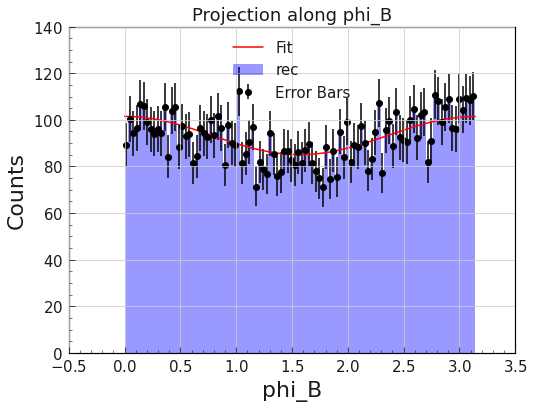

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import simps

# Define the ranges for each variable
cosTheta_K_range = np.linspace(-0.9, 1.0, 100)
cosTheta_L_range = np.linspace(0, 1.0, 100)
phi_B_range = np.linspace(0, np.pi, 100)

# Create a meshgrid of points
cosTheta_K_grid, cosTheta_L_grid, phi_B_grid = np.meshgrid(cosTheta_K_range, cosTheta_L_range, phi_B_range)

# Flatten the grids to evaluate the PDFs
points = np.vstack([cosTheta_K_grid.flatten(), cosTheta_L_grid.flatten(), phi_B_grid.flatten()]).T

# Evaluate the fitted PDFs at each point
pdf_values_gr = pdf_fit_signal_gr.pdf(points).numpy().reshape(cosTheta_K_grid.shape)

# Integration step over the entire 3D space
integrated_pdf_total = simps(simps(simps(pdf_values_gr, phi_B_range, axis=2), cosTheta_L_range, axis=1), cosTheta_K_range, axis=0)

# Find the number of events by normalizing the total integrated PDF
num_events_total = integrated_pdf_total * sum(mc_ele_only_signal_weight_fold)


print("Total number of events:", num_events_total)

# Integration and normalization steps for cosTheta_K
integrated_pdf_values_K = simps(simps(pdf_values_gr, phi_B_range, axis=2), cosTheta_L_range, axis=1)

pdf_values_K = integrated_pdf_values_K * sum(mc_ele_only_signal_weight_fold) * np.diff(cosTheta_K_range)[0]

# Integration and normalization steps for cosTheta_L
integrated_pdf_values_L = simps(simps(pdf_values_gr, phi_B_range, axis=2), cosTheta_K_range, axis=0)

pdf_values_L = integrated_pdf_values_L * sum(mc_ele_only_signal_weight_fold) * np.diff(cosTheta_L_range)[0]

# Integration and normalization steps for phi_B
integrated_pdf_values_B = simps(simps(pdf_values_gr, cosTheta_L_range, axis=1), cosTheta_K_range, axis=0)

pdf_values_B = integrated_pdf_values_B * sum(mc_ele_only_signal_weight_fold) * np.diff(phi_B_range)[0]

# Plot results for cosTheta_K
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_ele_only_signal_fold["cosTheta_K"], bins=100, weights=mc_ele_only_signal_weight_fold, density=False, alpha=0.4, label='rec', color='blue')
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_weights = [mc_ele_only_signal_weight_fold.iloc[np.where((mc_ele_only_signal_fold["cosTheta_K"] >= bins[i]) & (mc_ele_only_signal_fold["cosTheta_K"] < bins[i+1]))[0]].tolist() for i in range(len(bins) - 1)]
errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]
plt.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error Bars')
plt.plot(cosTheta_K_range, pdf_values_L, 'r', label='Fit')
plt.xlabel('cosTheta_K')
plt.xlim(-1.25, 1.25)
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along cosTheta_K')
plt.grid(True)

# Plot results for cosTheta_L
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_ele_only_signal_fold["cosTheta_L"], bins=100, weights=mc_ele_only_signal_weight_fold, density=False, alpha=0.4, label='rec', color='blue')
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_weights = [mc_ele_only_signal_weight_fold.iloc[np.where((mc_ele_only_signal_fold["cosTheta_L"] >= bins[i]) & (mc_ele_only_signal_fold["cosTheta_L"] < bins[i+1]))[0]].tolist() for i in range(len(bins) - 1)]
errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]
plt.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error')
plt.plot(cosTheta_L_range, pdf_values_K, 'r', label='Fit')
plt.xlabel('cosTheta_L')
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along cosTheta_L')
plt.grid(True)

# Plot results for phi_B
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_ele_only_signal_fold["phi_B"], bins=100, weights=mc_ele_only_signal_weight_fold, density=False, alpha=0.4,  label='rec', color='blue')
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_weights = [mc_ele_only_signal_weight_fold.iloc[np.where((mc_ele_only_signal_fold["phi_B"] >= bins[i]) & (mc_ele_only_signal_fold["phi_B"] < bins[i+1]))[0]].tolist() for i in range(len(bins) - 1)]
errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]
plt.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error Bars')
plt.plot(phi_B_range, pdf_values_B, 'r', label='Fit')
plt.xlabel('phi_B')
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along phi_B')
plt.grid(True)

plt.show()


In [15]:
electrons_gen = mc_ele_gen_only_signal[(mc_ele_gen_only_signal['lp_PDG'] == 11) | (mc_ele_gen_only_signal['lm_PDG'] == 11)]

# Find the number of events by normalizing the total integrated PDF
num_events_total_gen = len(electrons_gen)


num_events_total_rec_without_Acceptance_weights = num_events_total

# Efficiency calculation
efficiency = num_events_total_rec_without_Acceptance_weights / num_events_total_gen 

print(num_events_total_gen)
print(num_events_total_rec_without_Acceptance_weights)


print("Efficiency:", efficiency)

39680
9232.401501528238
Efficiency: 0.23267140880867537


In [16]:
from uncertainties import ufloat

cross_section_nb = 0.5346e-9  # Cross-section in nanobarns
luminosity_nb = 368.4e+15  # Luminosity in femtobarns

N_bb_mesons=cross_section_nb * (4*luminosity_nb)

print("No.BB* mesons:",N_bb_mesons)

N_Rect_signal = num_events_total_rec_without_Acceptance_weights
efficiency = efficiency

B_JPsi_to_ll = ufloat(5.971, 0.032) / 100  
B_K_to_K_pi = (ufloat(99.754, 0.021) / 100) * 2 / 3  # Divide by 100 and then multiply by 2/3

BR_MC = N_Rect_signal/ ((2*N_bb_mesons)*B_JPsi_to_ll*B_K_to_K_pi*efficiency)

BR_PDG=unc.ufloat(1.270e-3, 0.05e-3)
print(N_Rect_signal)
print(efficiency)
print("B _to_JPsi_and_K*_for_electron_Branching_ratio_from_fit_without_weight:",BR_MC)
print("B _to_JPsi_and_K*_Branching_ratio_from_PDG:",BR_PDG)


No.BB* mesons: 787786560.0
9232.401501528238
0.23267140880867537
B _to_JPsi_and_K*_for_electron_Branching_ratio_from_fit_without_weight: 0.0006342+/-0.0000034
B _to_JPsi_and_K*_Branching_ratio_from_PDG: 0.00127+/-0.00005


Total number of events: 9194.773272725353


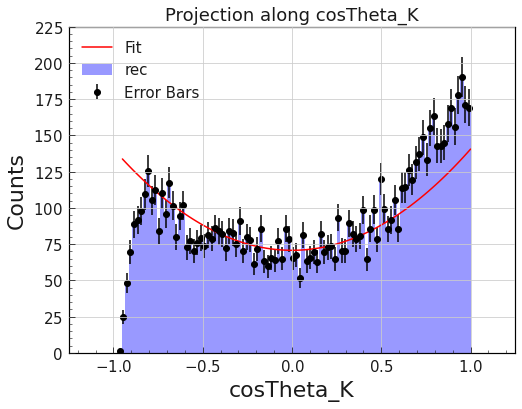

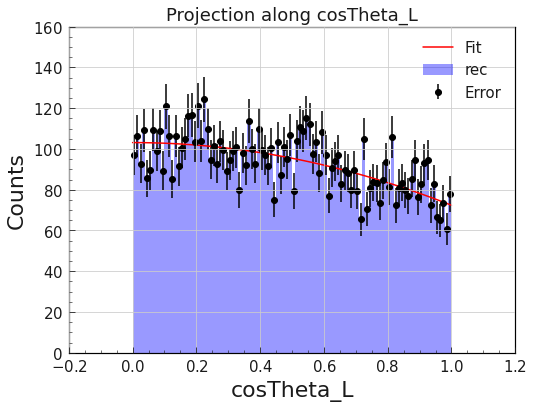

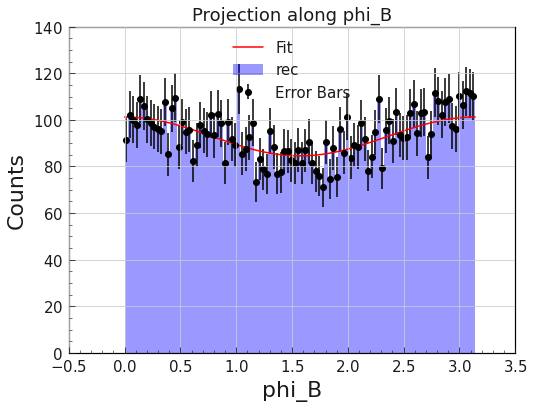

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import simps

# Define the ranges for each variable
cosTheta_K_range = np.linspace(-0.95, 1.0, 100)
cosTheta_L_range = np.linspace(0, 1.0, 100)
phi_B_range = np.linspace(0, np.pi, 100)

# Create a meshgrid of points
cosTheta_K_grid, cosTheta_L_grid, phi_B_grid = np.meshgrid(cosTheta_K_range, cosTheta_L_range, phi_B_range)

# Flatten the grids to evaluate the PDFs
points = np.vstack([cosTheta_K_grid.flatten(), cosTheta_L_grid.flatten(), phi_B_grid.flatten()]).T

# Evaluate the fitted PDFs at each point
pdf_values_gr = pdf_fit_signal_kl .pdf(points).numpy().reshape(cosTheta_K_grid.shape)

# Integration step over the entire 3D space
integrated_pdf_total = simps(simps(simps(pdf_values_gr, phi_B_range, axis=2), cosTheta_L_range, axis=1), cosTheta_K_range, axis=0)

# Find the number of events by normalizing the total integrated PDF
num_events_total_wo_klcut = integrated_pdf_total * sum(mc_ele_only_signal_weight_wo_klcut_fold)

print("Total number of events:", num_events_total_wo_klcut)

# Integration and normalization steps for cosTheta_K
integrated_pdf_values_K = simps(simps(pdf_values_gr, phi_B_range, axis=2), cosTheta_L_range, axis=1)

pdf_values_K = integrated_pdf_values_K * sum(mc_ele_only_signal_weight_wo_klcut_fold) * np.diff(cosTheta_K_range)[0]

# Integration and normalization steps for cosTheta_L
integrated_pdf_values_L = simps(simps(pdf_values_gr, phi_B_range, axis=2), cosTheta_K_range, axis=0)

pdf_values_L = integrated_pdf_values_L * sum(mc_ele_only_signal_weight_wo_klcut_fold) * np.diff(cosTheta_L_range)[0]

# Integration and normalization steps for phi_B
integrated_pdf_values_B = simps(simps(pdf_values_gr, cosTheta_L_range, axis=1), cosTheta_K_range, axis=0)

pdf_values_B = integrated_pdf_values_B * sum(mc_ele_only_signal_weight_wo_klcut_fold) * np.diff(phi_B_range)[0]

# Plot results for cosTheta_K
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_ele_only_signal_wo_klcut_fold["cosTheta_K"], bins=100, weights=mc_ele_only_signal_weight_wo_klcut_fold, density=False, alpha=0.4, label='rec', color='blue')
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_weights = [mc_ele_only_signal_weight_wo_klcut_fold.iloc[np.where((mc_ele_only_signal_wo_klcut_fold["cosTheta_K"] >= bins[i]) & (mc_ele_only_signal_wo_klcut_fold["cosTheta_K"] < bins[i+1]))[0]].tolist() for i in range(len(bins) - 1)]
errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]
plt.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error Bars')

plt.plot(cosTheta_K_range, pdf_values_L, 'r', label='Fit')

plt.xlabel('cosTheta_K')
plt.xlim(-1.25, 1.25)
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along cosTheta_K')
plt.grid(True)

# Plot results for cosTheta_L
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_ele_only_signal_wo_klcut_fold["cosTheta_L"], bins=100, weights=mc_ele_only_signal_weight_wo_klcut_fold, density=False, alpha=0.4, label='rec', color='blue')
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_weights = [mc_ele_only_signal_weight_wo_klcut_fold.iloc[np.where((mc_ele_only_signal_wo_klcut_fold["cosTheta_L"] >= bins[i]) & (mc_ele_only_signal_wo_klcut_fold["cosTheta_L"] < bins[i+1]))[0]].tolist() for i in range(len(bins) - 1)]
errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]
plt.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error')
plt.plot(cosTheta_L_range, pdf_values_K, 'r', label='Fit')
plt.xlabel('cosTheta_L')
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along cosTheta_L')
plt.grid(True)

# Plot results for phi_B
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_ele_only_signal_wo_klcut_fold["phi_B"], bins=100, weights=mc_ele_only_signal_weight_wo_klcut_fold, density=False, alpha=0.4,  label='rec', color='blue')
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_weights = [mc_ele_only_signal_weight_wo_klcut_fold.iloc[np.where((mc_ele_only_signal_wo_klcut_fold["phi_B"] >= bins[i]) & (mc_ele_only_signal_wo_klcut_fold["phi_B"] < bins[i+1]))[0]].tolist() for i in range(len(bins) - 1)]
errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]
plt.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error Bars')
plt.plot(phi_B_range, pdf_values_B, 'r', label='Fit')
plt.xlabel('phi_B')
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along phi_B')
plt.grid(True)

plt.show()


In [13]:
electrons_gen_wo_klcut = mc_ele_gen_only_signal_wo_klcut[(mc_ele_gen_only_signal_wo_klcut['lp_PDG'] == 11) | (mc_ele_gen_only_signal_wo_klcut['lm_PDG'] == 11)]

# Find the number of events by normalizing the total integrated PDF
num_events_total_gen = len(electrons_gen_wo_klcut)

num_events_total_rec_without_Acceptance_weights = num_events_total_wo_klcut

efficiency = num_events_total_rec_without_Acceptance_weights / num_events_total_gen 

print(num_events_total_gen)
print(num_events_total_rec_without_Acceptance_weights)


print("Efficiency:", efficiency)

43108
9194.773272725353
Efficiency: 0.21329621584683478


In [14]:
from uncertainties import ufloat

cross_section_nb = 0.5346e-9  # Cross-section in nanobarns
luminosity_nb = 368.4e+15  # Luminosity in femtobarns

N_bb_mesons=cross_section_nb * (4*luminosity_nb)

print("No.BB* mesons:",N_bb_mesons)

N_Rect_signal = num_events_total_rec_without_Acceptance_weights
efficiency = efficiency

B_JPsi_to_ll = ufloat(5.971, 0.032) / 100  
B_K_to_K_pi = (ufloat(99.754, 0.021) / 100) * 2 / 3  # Divide by 100 and then multiply by 2/3

BR_MC = N_Rect_signal/ ((2*N_bb_mesons)*B_JPsi_to_ll*B_K_to_K_pi*efficiency)

BR_PDG=unc.ufloat(1.270e-3, 0.05e-3)
print(N_Rect_signal)
print(efficiency)
print("B _to_JPsi_and_K*_for_electron_Branching_ratio_from_fit_without_weight:",BR_MC)
print("B _to_JPsi_and_K*_Branching_ratio_from_PDG:",BR_PDG)


No.BB* mesons: 787786560.0
9194.773272725353
0.21329621584683478
B _to_JPsi_and_K*_for_electron_Branching_ratio_from_fit_without_weight: 0.000689+/-0.000004
B _to_JPsi_and_K*_Branching_ratio_from_PDG: 0.00127+/-0.00005


## without weights

In [ ]:
import zfit
import tensorflow as tf
import pandas as pd
import numpy as np

class p5_prime_pdf(zfit.pdf.ZPDF):
    _N_OBS = 3  # dimension, can be omitted
    _PARAMS = ['param_fl','param_s3','param_p5']  # the name of the parameters

    def _unnormalized_pdf(self, x):
        x, y, z = x.unstack_x()  # x=costk, y=costl, z=phib
        param_fl = self.params['param_fl']
        param_s3 = self.params['param_s3']
        param_p5 = self.params['param_p5']
        
        return (9/(8*np.pi))*((3/4)*(1-param_fl)* (1-x**2) + param_fl * x**2 + \
               (1/4) *(1 - param_fl)* (1-x**2)* (2 * y**2 - 1)- \
               param_fl * x**2 * (2 * y**2 - 1) + param_s3 *(1-x**2)*(1-y**2) * tf.cos(2*z)+ \
               tf.sqrt(param_fl*(1-param_fl)) * param_p5 * 2*tf.sqrt(1-x**2) *x * tf.sqrt(1-y**2)* tf.cos(z))

def p5p_3D_fit(cost_k_data, cost_l_data, phi_b_data, param_fl_start, param_s3_start, param_p5_start, floating=True):
    # create space
    obs_cost_k = zfit.Space('cosTheta_K', limits=(min(cost_k_data), max(cost_k_data)))
    obs_cost_l = zfit.Space('cosTheta_L', limits=(min(cost_l_data), max(cost_l_data)))
    obs_phi_b = zfit.Space('phi_B', limits=(0, np.pi))
    obs = obs_cost_k * obs_cost_l * obs_phi_b

    # data
    df_sig = pd.concat([cost_k_data, cost_l_data, phi_b_data], axis=1)
    df_sig.columns = ['cosTheta_K', 'cosTheta_L', 'phi_B']  # Renaming columns to match observables
    data_fit_sig = zfit.Data.from_pandas(df_sig, obs=obs)

    # parameter variable
    r = np.round(np.random.rand(), decimals=8)

    # parameters
    param_fl = zfit.Parameter(f'param_fl_{r}', param_fl_start, floating=floating)
    param_s3 = zfit.Parameter(f'param_s3_{r}', param_s3_start, floating=floating)
    param_p5 = zfit.Parameter(f'param_p5_{r}', param_p5_start, floating=floating)

    extended = zfit.Parameter(f"extended_{r}", 10000)

    pdf_3D = p5_prime_pdf(param_fl=param_fl, param_s3=param_s3, param_p5=param_p5, obs=obs, extended=extended)
    pdf_3D.update_integration_options(max_draws=10000, tol=1e-4)  # Adjust parameters as needed

    # create NLL
    nll = zfit.loss.ExtendedUnbinnedNLL(model=pdf_3D, data=data_fit_sig)
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)

    if floating == True:
        result.hesse(name='hesse')

    print(result.params)
    print("Fit result valid:")
    print(result.valid)

    return pdf_3D

def fold_data(data):
    data['cosTheta_L'] = data['cosTheta_L'].abs()
    phi_b_gr = data.query(f"phi_B > {np.pi}")
    phi_b_gr['phi_B'] = 2 * np.pi - phi_b_gr['phi_B']
    phi_b_kl = data.query(f"phi_B <= {np.pi}")
    folded_data = pd.concat([phi_b_kl, phi_b_gr])
    return folded_data

mc_ele_only_signal_fold = fold_data(mc_ele_only_signal)
mc_ele_only_signal_wo_klcut_fold = fold_data(mc_ele_only_signal_wo_klcut)

mc_ele_only_signal_weight_fold = mc_ele_only_signal_fold["PIDCorrectionAndAcceptanceWeight"]
mc_ele_only_signal_weight_wo_klcut_fold = mc_ele_only_signal_wo_klcut_fold["PIDCorrectionAndAcceptanceWeight"]

# Example usage with adjusted starting parameters
param_fl_start = 0.5  # Adjust based on your data
param_s3_start = 0.01  # Adjust based on your data
param_p5_start = 0.02  # Adjust based on your data

# Reconstructed signal events
print("Reconstructed Signal Events:")
pdf_fit_signal_gr_wo_weights = p5p_3D_fit(mc_ele_only_signal_fold["cosTheta_K"], mc_ele_only_signal_fold["cosTheta_L"], mc_ele_only_signal_fold["phi_B"],
                               param_fl_start, param_s3_start, param_p5_start, floating=True)
pdf_fit_signal_kl_wo_weights = p5p_3D_fit(mc_ele_only_signal_wo_klcut_fold["cosTheta_K"], mc_ele_only_signal_wo_klcut_fold["cosTheta_L"], mc_ele_only_signal_wo_klcut_fold["phi_B"],
                               param_fl_start, param_s3_start, param_p5_start, floating=True)

# Calculate total signal events
mc_ele_only_signal_MC_data = len(mc_ele_only_signal_fold)
mc_ele_only_signal_MC_data_wo_klcut = len(mc_ele_only_signal_wo_klcut_fold)

print("Signal Events in MC Data =", mc_ele_only_signal_MC_data)
print("Signal Events in MC Data_wo_klcut =", mc_ele_only_signal_MC_data_wo_klcut)

# generatic signal events

def fold_data(data):
    data['cosTheta_L_mc'] = data['cosTheta_L_mc'].abs()
    phi_b_gr = data.query(f"phi_B_mc > {np.pi}")
    phi_b_gr['phi_B_mc'] = 2 * np.pi - phi_b_gr['phi_B_mc']
    phi_b_kl = data.query(f"phi_B_mc <= {np.pi}")
    folded_data = pd.concat([phi_b_kl, phi_b_gr])
    return folded_data

mc_ele_only_signal_truth_fold = fold_data(mc_ele_only_signal)
mc_ele_only_signal_truth_wo_klcut_fold = fold_data(mc_ele_only_signal_wo_klcut)

mc_ele_only_signal_truth_weight_fold = mc_ele_only_signal_fold["PIDCorrectionAndAcceptanceWeight"]
mc_ele_only_signal_truth_weight_wo_klcut_fold = mc_ele_only_signal_wo_klcut_fold["PIDCorrectionAndAcceptanceWeight"]


print("mc_truth Signal Events:")
mc_ele_only_signal_truth_fold = fold_data(mc_ele_only_signal)
mc_ele_only_signal_truth_wo_klcut_fold = fold_data(mc_ele_only_signal_wo_klcut)

mc_ele_only_signal_truth_weight_fold = mc_ele_only_signal_truth_fold["PIDCorrectionAndAcceptanceWeight"]
mc_ele_only_signal_truth_weight_wo_klcut_fold = mc_ele_only_signal_truth_wo_klcut_fold["PIDCorrectionAndAcceptanceWeight"]

pdf_fit_signal_mc_truth_gr_wo_weights = p5p_3D_fit(mc_ele_only_signal_truth_fold["cosTheta_K_mc"], mc_ele_only_signal_truth_fold["cosTheta_L_mc"], mc_ele_only_signal_truth_fold["phi_B_mc"],
                               param_fl_start, param_s3_start, param_p5_start, floating=True)
pdf_fit_signal_mc_truth_kl_wo_weights = p5p_3D_fit(mc_ele_only_signal_truth_wo_klcut_fold["cosTheta_K_mc"], mc_ele_only_signal_truth_wo_klcut_fold["cosTheta_L_mc"], mc_ele_only_signal_truth_wo_klcut_fold["phi_B_mc"],
                               param_fl_start, param_s3_start, param_p5_start, floating=True)

# Calculate total signal events
mc_ele_only_signal_truth_MC_data = len(mc_ele_only_signal_truth_fold)
mc_ele_only_signal_truth_MC_data_wo_klcut = len(mc_ele_only_signal_truth_wo_klcut_fold)

print("Signal Events in MC Data =", mc_ele_only_signal_truth_MC_data)
print("Signal Events in MC Data_wo_klcut =", mc_ele_only_signal_truth_MC_data_wo_klcut)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import simps

# Define the ranges for each variable
cosTheta_K_range = np.linspace(-0.9, 1.0, 100)
cosTheta_L_range = np.linspace(0, 1.0, 100)
phi_B_range = np.linspace(0, np.pi, 100)

# Create a meshgrid of points
cosTheta_K_gr_wo_weightsid, cosTheta_L_gr_wo_weightsid, phi_B_gr_wo_weightsid = np.meshgrid(cosTheta_K_range, cosTheta_L_range, phi_B_range)

# Flatten the grids to evaluate the PDFs
points = np.vstack([cosTheta_K_gr_wo_weightsid.flatten(), cosTheta_L_gr_wo_weightsid.flatten(), phi_B_gr_wo_weightsid.flatten()]).T

# Evaluate the fitted PDFs at each point
pdf_truth_values_gr_wo_weights = pdf_fit_signal_mc_truth_gr_wo_weights.pdf(points).numpy().reshape(cosTheta_K_gr_wo_weightsid.shape)
pdf_values_gr_wo_weights = pdf_fit_signal_gr_wo_weights.pdf(points).numpy().reshape(cosTheta_K_gr_wo_weightsid.shape)

# Integration step over the entire 3D space
integrated_pdf_total_truth = simps(simps(simps(pdf_truth_values_gr_wo_weights, phi_B_range, axis=2), cosTheta_L_range, axis=1), cosTheta_K_range, axis=0)
integrated_pdf_total = simps(simps(simps(pdf_values_gr_wo_weights, phi_B_range, axis=2), cosTheta_L_range, axis=1), cosTheta_K_range, axis=0)

# Find the number of events by normalizing the total integrated PDF
num_events_total_truth = integrated_pdf_total_truth * len(mc_ele_only_signal_truth_fold)
num_events_total = integrated_pdf_total * len(mc_ele_only_signal_fold)

print("Total number of events (MC_truth, without weights):", num_events_total_truth)
print("Total number of events (without weights):", num_events_total)

# Integration and normalization steps for cosTheta_K
integrated_pdf_truth_values_K = simps(simps(pdf_truth_values_gr_wo_weights, phi_B_range, axis=2), cosTheta_L_range, axis=1)
integrated_pdf_values_K = simps(simps(pdf_values_gr_wo_weights, phi_B_range, axis=2), cosTheta_L_range, axis=1)

pdf_truth_values_K = integrated_pdf_truth_values_K * len(mc_ele_only_signal_truth_fold) * np.diff(cosTheta_K_range)[0]
pdf_values_K = integrated_pdf_values_K * len(mc_ele_only_signal_fold) * np.diff(cosTheta_K_range)[0]

# Integration and normalization steps for cosTheta_L
integrated_pdf_truth_values_L = simps(simps(pdf_truth_values_gr_wo_weights, phi_B_range, axis=2), cosTheta_K_range, axis=0)
integrated_pdf_values_L = simps(simps(pdf_values_gr_wo_weights, phi_B_range, axis=2), cosTheta_K_range, axis=0)

pdf_truth_values_L = integrated_pdf_truth_values_L * len(mc_ele_only_signal_truth_fold) * np.diff(cosTheta_L_range)[0]
pdf_values_L = integrated_pdf_values_L * len(mc_ele_only_signal_fold) * np.diff(cosTheta_L_range)[0]

# Integration and normalization steps for phi_B
integrated_pdf_truth_values_B = simps(simps(pdf_truth_values_gr_wo_weights, cosTheta_L_range, axis=1), cosTheta_K_range, axis=0)
integrated_pdf_values_B = simps(simps(pdf_values_gr_wo_weights, cosTheta_L_range, axis=1), cosTheta_K_range, axis=0)

pdf_truth_values_B = integrated_pdf_truth_values_B * len(mc_ele_only_signal_truth_fold) * np.diff(phi_B_range)[0]
pdf_values_B = integrated_pdf_values_B * len(mc_ele_only_signal_fold) * np.diff(phi_B_range)[0]

# Plot results for cosTheta_K
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_ele_only_signal_fold["cosTheta_K"], bins=100, density=False, alpha=0.4, label='rec', color='blue')
n_truth, _, _ = plt.hist(mc_ele_only_signal_truth_fold["cosTheta_K_mc"], bins=100, density=False, alpha=0.4, label='mc_truth', color='orange')
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(cosTheta_K_range, pdf_values_L, 'r', label='Fit')
plt.plot(cosTheta_K_range, pdf_truth_values_L, 'g', label='Fit(mc_truth)')
plt.xlabel('cosTheta_K')
plt.xlim(-1.25, 1.25)
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along cosTheta_K')
plt.grid(True)

# Plot results for cosTheta_L
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_ele_only_signal_fold["cosTheta_L"], bins=100, density=False, alpha=0.4, label='rec', color='blue')
n_truth, _, _ = plt.hist(mc_ele_only_signal_truth_fold["cosTheta_L_mc"], bins=100, density=False, alpha=0.4, label='mc_truth', color='orange')
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(cosTheta_L_range, pdf_values_K, 'r', label='Fit')
plt.plot(cosTheta_L_range, pdf_truth_values_K, 'g', label='Fit(mc_truth)')
plt.xlabel('cosTheta_L')
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along cosTheta_L')
plt.grid(True)

# Plot results for phi_B
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_ele_only_signal_fold["phi_B"], bins=100, density=False, alpha=0.4, label='rec', color='blue')
n_truth, _, _ = plt.hist(mc_ele_only_signal_truth_fold["phi_B_mc"], bins=100, density=False, alpha=0.4, label='mc_truth', color='orange')
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(phi_B_range, pdf_values_B, 'r', label='Fit')
plt.plot(phi_B_range, pdf_truth_values_B, 'g', label='Fit(mc_truth)')
plt.xlabel('phi_B')
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along phi_B')
plt.grid(True)

plt.show()


In [ ]:
# Total number of events with weights
num_events_total_truth_with_weights = sum(mc_ele_only_signal_truth_weight_fold)
num_events_total_with_weights = sum(mc_ele_only_signal_weight_fold)


# Find the number of events by normalizing the total integrated PDF
num_events_total_truth_without_weights = len(mc_ele_only_signal_truth_fold)
num_events_total_without_weights = len(mc_ele_only_signal_fold)

# Efficiency calculation
efficiency_truth = num_events_total_truth_with_weights / num_events_total_truth_without_weights
efficiency = num_events_total_with_weights / num_events_total_without_weights

print("Efficiency (MC_truth):", efficiency_truth)
print("Efficiency:", efficiency)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import simps

# Define the ranges for each variable
cosTheta_K_range = np.linspace(-0.9, 1.0, 100)
cosTheta_L_range = np.linspace(0, 1.0, 100)
phi_B_range = np.linspace(0, np.pi, 100)

# Create a meshgrid of points
cosTheta_K_kl_wo_weightsid, cosTheta_L_kl_wo_weightsid, phi_B_kl_wo_weightsid = np.meshgrid(cosTheta_K_range, cosTheta_L_range, phi_B_range)

# Flatten the grids to evaluate the PDFs
points = np.vstack([cosTheta_K_kl_wo_weightsid.flatten(), cosTheta_L_kl_wo_weightsid.flatten(), phi_B_kl_wo_weightsid.flatten()]).T

# Evaluate the fitted PDFs at each point
pdf_truth_values_kl_wo_weights = pdf_fit_signal_mc_truth_kl_wo_weights.pdf(points).numpy().reshape(cosTheta_K_kl_wo_weightsid.shape)
pdf_values_kl_wo_weights = pdf_fit_signal_kl_wo_weights.pdf(points).numpy().reshape(cosTheta_K_kl_wo_weightsid.shape)

# Integration step over the entire 3D space
integrated_pdf_total_truth = simps(simps(simps(pdf_truth_values_kl_wo_weights, phi_B_range, axis=2), cosTheta_L_range, axis=1), cosTheta_K_range, axis=0)
integrated_pdf_total = simps(simps(simps(pdf_values_kl_wo_weights, phi_B_range, axis=2), cosTheta_L_range, axis=1), cosTheta_K_range, axis=0)

# Find the number of events by normalizing the total integrated PDF
num_events_total_truth = integrated_pdf_total_truth * len(mc_ele_only_signal_truth_wo_klcut_fold)
num_events_total = integrated_pdf_total * len(mc_ele_only_signal_wo_klcut_fold)

print("Total number of events (MC_truth, without weights):", num_events_total_truth)
print("Total number of events (without weights):", num_events_total)

# Integration and normalization steps for cosTheta_K
integrated_pdf_truth_values_K = simps(simps(pdf_truth_values_kl_wo_weights, phi_B_range, axis=2), cosTheta_L_range, axis=1)
integrated_pdf_values_K = simps(simps(pdf_values_kl_wo_weights, phi_B_range, axis=2), cosTheta_L_range, axis=1)

pdf_truth_values_K = integrated_pdf_truth_values_K * len(mc_ele_only_signal_truth_wo_klcut_fold) * np.diff(cosTheta_K_range)[0]
pdf_values_K = integrated_pdf_values_K * len(mc_ele_only_signal_wo_klcut_fold) * np.diff(cosTheta_K_range)[0]

# Integration and normalization steps for cosTheta_L
integrated_pdf_truth_values_L = simps(simps(pdf_truth_values_kl_wo_weights, phi_B_range, axis=2), cosTheta_K_range, axis=0)
integrated_pdf_values_L = simps(simps(pdf_values_kl_wo_weights, phi_B_range, axis=2), cosTheta_K_range, axis=0)

pdf_truth_values_L = integrated_pdf_truth_values_L * len(mc_ele_only_signal_truth_wo_klcut_fold) * np.diff(cosTheta_L_range)[0]
pdf_values_L = integrated_pdf_values_L * len(mc_ele_only_signal_wo_klcut_fold) * np.diff(cosTheta_L_range)[0]

# Integration and normalization steps for phi_B
integrated_pdf_truth_values_B = simps(simps(pdf_truth_values_kl_wo_weights, cosTheta_L_range, axis=1), cosTheta_K_range, axis=0)
integrated_pdf_values_B = simps(simps(pdf_values_kl_wo_weights, cosTheta_L_range, axis=1), cosTheta_K_range, axis=0)

pdf_truth_values_B = integrated_pdf_truth_values_B * len(mc_ele_only_signal_truth_wo_klcut_fold) * np.diff(phi_B_range)[0]
pdf_values_B = integrated_pdf_values_B * len(mc_ele_only_signal_wo_klcut_fold) * np.diff(phi_B_range)[0]

# Plot results for cosTheta_K
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_ele_only_signal_wo_klcut_fold["cosTheta_K"], bins=100, density=False, alpha=0.4, label='rec', color='blue')
n_truth, _, _ = plt.hist(mc_ele_only_signal_truth_wo_klcut_fold["cosTheta_K_mc"], bins=100, density=False, alpha=0.4, label='mc_truth', color='orange')
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(cosTheta_K_range, pdf_values_L, 'r', label='Fit')
plt.plot(cosTheta_K_range, pdf_truth_values_L, 'g', label='Fit(mc_truth)')
plt.xlabel('cosTheta_K')
plt.xlim(-1.25, 1.25)
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along cosTheta_K')
plt.grid(True)

# Plot results for cosTheta_L
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_ele_only_signal_wo_klcut_fold["cosTheta_L"], bins=100, density=False, alpha=0.4, label='rec', color='blue')
n_truth, _, _ = plt.hist(mc_ele_only_signal_truth_wo_klcut_fold["cosTheta_L_mc"], bins=100, density=False, alpha=0.4, label='mc_truth', color='orange')
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(cosTheta_L_range, pdf_values_K, 'r', label='Fit')
plt.plot(cosTheta_L_range, pdf_truth_values_K, 'g', label='Fit(mc_truth)')
plt.xlabel('cosTheta_L')
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along cosTheta_L')
plt.grid(True)

# Plot results for phi_B
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_ele_only_signal_wo_klcut_fold["phi_B"], bins=100, density=False, alpha=0.4, label='rec', color='blue')
n_truth, _, _ = plt.hist(mc_ele_only_signal_truth_wo_klcut_fold["phi_B_mc"], bins=100, density=False, alpha=0.4, label='mc_truth', color='orange')
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(phi_B_range, pdf_values_B, 'r', label='Fit')
plt.plot(phi_B_range, pdf_truth_values_B, 'g', label='Fit(mc_truth)')
plt.xlabel('phi_B')
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along phi_B')
plt.grid(True)

plt.show()


In [ ]:
# Total number of events with weights
num_events_total_truth_with_weights = sum(mc_ele_only_signal_truth_weight_wo_klcut_fold)
num_events_total_with_weights = sum(mc_ele_only_signal_weight_wo_klcut_fold)


# Find the number of events by normalizing the total integrated PDF
num_events_total_truth_without_weights = len(mc_ele_only_signal_truth_wo_klcut_fold)
num_events_total_without_weights = len(mc_ele_only_signal_wo_klcut_fold)

# Efficiency calculation
efficiency_truth = num_events_total_truth_with_weights / num_events_total_truth_without_weights
efficiency = num_events_total_with_weights / num_events_total_without_weights

print("Efficiency (MC_truth):", efficiency_truth)
print("Efficiency:", efficiency)

## Genrative 

In [ ]:
import zfit
import tensorflow as tf
import pandas as pd
import numpy as np

class p5_prime_pdf(zfit.pdf.ZPDF):
    _N_OBS = 3  # dimension, can be omitted
    _PARAMS = ['param_fl','param_s3','param_p5']  # the name of the parameters

    def _unnormalized_pdf(self, x):
        x, y, z = x.unstack_x()  # x=costk, y=costl, z=phib
        param_fl = self.params['param_fl']
        param_s3 = self.params['param_s3']
        param_p5 = self.params['param_p5']
        
        return (9/(8*np.pi))*((3/4)*(1-param_fl)* (1-x**2) + param_fl * x**2 + \
               (1/4) *(1 - param_fl)* (1-x**2)* (2 * y**2 - 1)- \
               param_fl * x**2 * (2 * y**2 - 1) + param_s3 *(1-x**2)*(1-y**2) * tf.cos(2*z)+ \
               tf.sqrt(param_fl*(1-param_fl)) * param_p5 * 2*tf.sqrt(1-x**2) *x * tf.sqrt(1-y**2)* tf.cos(z))

def p5p_3D_fit(cost_k_data, cost_l_data, phi_b_data, param_fl_start, param_s3_start, param_p5_start, floating=True):
    # create space
    obs_cost_k = zfit.Space('cosTheta_K', limits=(min(cost_k_data), max(cost_k_data)))
    obs_cost_l = zfit.Space('cosTheta_L', limits=(min(cost_l_data), max(cost_l_data)))
    obs_phi_b = zfit.Space('phi_B', limits=(0, np.pi))
    obs = obs_cost_k * obs_cost_l * obs_phi_b

    # data
    df_sig = pd.concat([cost_k_data, cost_l_data, phi_b_data], axis=1)
    df_sig.columns = ['cosTheta_K', 'cosTheta_L', 'phi_B']  # Renaming columns to match observables
    data_fit_sig = zfit.Data.from_pandas(df_sig, obs=obs)

    # parameter variable
    r = np.round(np.random.rand(), decimals=8)

    # parameters
    param_fl = zfit.Parameter(f'param_fl_{r}', param_fl_start, floating=floating)
    param_s3 = zfit.Parameter(f'param_s3_{r}', param_s3_start, floating=floating)
    param_p5 = zfit.Parameter(f'param_p5_{r}', param_p5_start, floating=floating)

    extended = zfit.Parameter(f"extended_{r}", 10000)

    pdf_3D = p5_prime_pdf(param_fl=param_fl, param_s3=param_s3, param_p5=param_p5, obs=obs, extended=extended)
    pdf_3D.update_integration_options(max_draws=10000, tol=1e-4)  # Adjust parameters as needed

    # create NLL
    nll = zfit.loss.ExtendedUnbinnedNLL(model=pdf_3D, data=data_fit_sig)
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)

    if floating == True:
        result.hesse(name='hesse')

    print(result.params)
    print("Fit result valid:")
    print(result.valid)

    return pdf_3D

def fold_data(data):
    data['cosTheta_L'] = data['cosTheta_L'].abs()
    phi_b_gr = data.query(f"phi_B > {np.pi}")
    phi_b_gr['phi_B'] = 2 * np.pi - phi_b_gr['phi_B']
    phi_b_kl = data.query(f"phi_B <= {np.pi}")
    folded_data = pd.concat([phi_b_kl, phi_b_gr])
    return folded_data

mc_ele_gen_only_signal_fold = fold_data(mc_ele_gen_only_signal)
mc_ele_gen_only_signal_wo_klcut_fold = fold_data(mc_ele_gen_only_signal_wo_klcut)


# Example usage with adjusted starting parameters
param_fl_start = 0.5  # Adjust based on your data
param_s3_start = 0.01  # Adjust based on your data
param_p5_start = 0.02  # Adjust based on your data

# Reconstructed signal events
print("Genrative Signal Events:")
pdf_fit_signal_mc_gen_gr = p5p_3D_fit(mc_ele_gen_only_signal_fold["cosTheta_K"], mc_ele_gen_only_signal_fold["cosTheta_L"], mc_ele_gen_only_signal_fold["phi_B"],
                               param_fl_start, param_s3_start, param_p5_start, floating=True)
pdf_fit_signal_mc_gen_kl = p5p_3D_fit(mc_ele_gen_only_signal_wo_klcut_fold["cosTheta_K"], mc_ele_gen_only_signal_wo_klcut_fold["cosTheta_L"], mc_ele_gen_only_signal_wo_klcut_fold["phi_B"],
                               param_fl_start, param_s3_start, param_p5_start, floating=True)

# Calculate total signal events
mc_ele_gen_only_signal_MC_data = len(mc_ele_gen_only_signal_fold)
mc_ele_gen_only_signal_MC_data_wo_klcut = len(mc_ele_gen_only_signal_wo_klcut_fold)

print("Signal Events in MC Data =", mc_ele_gen_only_signal_MC_data)
print("Signal Events in MC Data_wo_klcut =", mc_ele_gen_only_signal_MC_data_wo_klcut)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import simps

# Define the ranges for each variable
cosTheta_K_range = np.linspace(-0.9, 1.0, 100)
cosTheta_L_range = np.linspace(0, 1.0, 100)
phi_B_range = np.linspace(0, np.pi, 100)

# Create a meshgrid of points
cosTheta_K_gr_wo_weightsid, cosTheta_L_gr_wo_weightsid, phi_B_gr_wo_weightsid = np.meshgrid(cosTheta_K_range, cosTheta_L_range, phi_B_range)

# Flatten the grids to evaluate the PDFs
points = np.vstack([cosTheta_K_gr_wo_weightsid.flatten(), cosTheta_L_gr_wo_weightsid.flatten(), phi_B_gr_wo_weightsid.flatten()]).T

# Evaluate the fitted PDFs at each point
pdf_values_mc_gen_gr = pdf_fit_signal_mc_gen_gr.pdf(points).numpy().reshape(cosTheta_K_gr_wo_weightsid.shape)

# Integration step over the entire 3D space
integrated_pdf_total = simps(simps(simps(pdf_values_mc_gen_gr, phi_B_range, axis=2), cosTheta_L_range, axis=1), cosTheta_K_range, axis=0)

# Find the number of events by normalizing the total integrated PDF
num_events_total = integrated_pdf_total * len(mc_ele_gen_only_signal_fold)

print("Total number of events (without weights):", num_events_total)

# Integration and normalization steps for cosTheta_K
integrated_pdf_values_K = simps(simps(pdf_values_mc_gen_gr , phi_B_range, axis=2), cosTheta_L_range, axis=1)

pdf_values_K = integrated_pdf_values_K * len(mc_ele_gen_only_signal_fold) * np.diff(cosTheta_K_range)[0]

# Integration and normalization steps for cosTheta_L
integrated_pdf_values_L = simps(simps(pdf_values_mc_gen_gr , phi_B_range, axis=2), cosTheta_K_range, axis=0)

pdf_values_L = integrated_pdf_values_L * len(mc_ele_gen_only_signal_fold) * np.diff(cosTheta_L_range)[0]

# Integration and normalization steps for phi_B
integrated_pdf_values_B = simps(simps(pdf_values_mc_gen_gr , cosTheta_L_range, axis=1), cosTheta_K_range, axis=0)

pdf_values_B = integrated_pdf_values_B * len(mc_ele_gen_only_signal_fold) * np.diff(phi_B_range)[0]

# Plot results for cosTheta_K
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_ele_gen_only_signal_fold["cosTheta_K"], bins=100, density=False, alpha=0.4, label='rec', color='blue')
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(cosTheta_K_range, pdf_values_L, 'r', label='Fit')
plt.xlabel('cosTheta_K')
plt.xlim(-1.25, 1.25)
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along cosTheta_K')
plt.grid(True)

# Plot results for cosTheta_L
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_ele_gen_only_signal_fold["cosTheta_L"], bins=100, density=False, alpha=0.4, label='rec', color='blue')
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(cosTheta_L_range, pdf_values_K, 'r', label='Fit')
plt.xlabel('cosTheta_L')
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along cosTheta_L')
plt.grid(True)

# Plot results for phi_B
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_ele_gen_only_signal_fold["phi_B"], bins=100, density=False, alpha=0.4, label='rec', color='blue')
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(phi_B_range, pdf_values_B, 'r', label='Fit')
plt.xlabel('phi_B')
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along phi_B')
plt.grid(True)

plt.show()


In [ ]:
# Find the number of events by normalizing the total integrated PDF
num_events_total_gen = 82411.011
num_events_total_rec_without_weights = 9312.014

# Efficiency calculation
efficiency = num_events_total_gen / num_events_total_rec_without_weights


print("Efficiency:", efficiency)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import simps

# Define the ranges for each variable
cosTheta_K_range = np.linspace(-1.0, 1.0, 100)
cosTheta_L_range = np.linspace(0, 1.0, 100)
phi_B_range = np.linspace(0, np.pi, 100)

# Create a meshgrid of points
cosTheta_K_kl_wo_weightsid, cosTheta_L_kl_wo_weightsid, phi_B_kl_wo_weightsid = np.meshgrid(cosTheta_K_range, cosTheta_L_range, phi_B_range)

# Flatten the grids to evaluate the PDFs
points = np.vstack([cosTheta_K_kl_wo_weightsid.flatten(), cosTheta_L_kl_wo_weightsid.flatten(), phi_B_kl_wo_weightsid.flatten()]).T

# Evaluate the fitted PDFs at each point
pdf_values_mc_gen_kl = pdf_fit_signal_mc_gen_kl.pdf(points).numpy().reshape(cosTheta_K_kl_wo_weightsid.shape)

# Integration step over the entire 3D space
integrated_pdf_total = simps(simps(simps(pdf_values_mc_gen_kl, phi_B_range, axis=2), cosTheta_L_range, axis=1), cosTheta_K_range, axis=0)

# Find the number of events by normalizing the total integrated PDF
num_events_total = integrated_pdf_total * len(mc_ele_gen_only_signal_wo_klcut_fold)

print("Total number of events (without weights):", num_events_total)

# Integration and normalization steps for cosTheta_K
integrated_pdf_values_K = simps(simps(pdf_values_mc_gen_kl , phi_B_range, axis=2), cosTheta_L_range, axis=1)

pdf_values_K = integrated_pdf_values_K * len(mc_ele_gen_only_signal_wo_klcut_fold) * np.diff(cosTheta_K_range)[0]

# Integration and normalization steps for cosTheta_L
integrated_pdf_values_L = simps(simps(pdf_values_mc_gen_kl , phi_B_range, axis=2), cosTheta_K_range, axis=0)

pdf_values_L = integrated_pdf_values_L * len(mc_ele_gen_only_signal_wo_klcut_fold) * np.diff(cosTheta_L_range)[0]

# Integration and normalization steps for phi_B
integrated_pdf_values_B = simps(simps(pdf_values_mc_gen_kl , cosTheta_L_range, axis=1), cosTheta_K_range, axis=0)

pdf_values_B = integrated_pdf_values_B * len(mc_ele_gen_only_signal_wo_klcut_fold) * np.diff(phi_B_range)[0]

# Plot results for cosTheta_K
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_ele_gen_only_signal_wo_klcut_fold["cosTheta_K"], bins=100, density=False, alpha=0.4, label='rec', color='blue')
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(cosTheta_K_range, pdf_values_L, 'r', label='Fit')
plt.xlabel('cosTheta_K')
plt.xlim(-1.25, 1.25)
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along cosTheta_K')
plt.grid(True)

# Plot results for cosTheta_L
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_ele_gen_only_signal_wo_klcut_fold["cosTheta_L"], bins=100, density=False, alpha=0.4, label='rec', color='blue')
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(cosTheta_L_range, pdf_values_K, 'r', label='Fit')
plt.xlabel('cosTheta_L')
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along cosTheta_L')
plt.grid(True)

# Plot results for phi_B
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_ele_gen_only_signal_wo_klcut_fold["phi_B"], bins=100, density=False, alpha=0.4, label='rec', color='blue')
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(phi_B_range, pdf_values_B, 'r', label='Fit')
plt.xlabel('phi_B')
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along phi_B')
plt.grid(True)

plt.show()


In [ ]:
# Find the number of events by normalizing the total integrated PDF
num_events_total_gen = 89610.326
num_events_total_rec_without_weights = 8940.021

# Efficiency calculation
efficiency = num_events_total_gen / num_events_total_rec_without_weights


print("Efficiency:", efficiency)

## Braching ratio ##

In [ ]:
import uncertainties as unc



# Before angular cut

## reconstract

In [ ]:
Total number of events (MC_truth): 41421.04506900512
Total number of events: 41337.28456736621

In [31]:
from uncertainties import ufloat

cross_section_nb = 0.5346e-9  # Cross-section in nanobarns
luminosity_nb = 368.4e+15  # Luminosity in femtobarns


N_bb_mesons=cross_section_nb * (4*luminosity_nb)

print("No.BB* mesons:",N_bb_mesons)

N_signal_yield = 43108
B_JPsi_decay_ll = ufloat(5.971, 0.032) / 100  
B_K_decay_K+_pi = (ufloat(99.754, 0.021) / 100) * 2 / 3  # Divide by 100 and then multiply by 2/3

BR_MC = N_signal_yield / ((2*N_bb_mesons)*B_JPsi_to_ll*B_K_to_K_pi)

BR_PDG=unc.ufloat(1.270e-3, 0.05e-3)

print("B _to_JPsi_and_K*_for_electron_Branching_ratio_from_fit_without_weight:",BR_MC)
print("B _to_JPsi_and_K*_Branching_ratio_from_PDG:",BR_PDG)


No.BB* mesons: 787786560.0
B _to_JPsi_and_K*_for_electron_Branching_ratio_from_fit_without_weight: 0.000689+/-0.000004
B _to_JPsi_and_K*_Branching_ratio_from_PDG: 0.00127+/-0.00005


## Mc_truth

In [32]:
N_signal_yield = 39680
B_JPsi_to_ll = ufloat(5.971, 0.032) / 100  
B_K_to_K_pi = (ufloat(99.754, 0.021) / 100) * 2 / 3  # Divide by 100 and then multiply by 2/3

BR_MC = N_signal_yield / ((2 * N_bb_mesons)*B_JPsi_to_ll*B_K_to_K_pi)

BR_PDG=unc.ufloat(1.270e-3, 0.05e-3)

print("B _to_JPsi_and_K*_for_electron_Branching_ratio_from_fit_without_weight:",BR_MC)
print("B _to_JPsi_and_K*_Branching_ratio_from_PDG:",BR_PDG)


B _to_JPsi_and_K*_for_electron_Branching_ratio_from_fit_without_weight: 0.0006342+/-0.0000034
B _to_JPsi_and_K*_Branching_ratio_from_PDG: 0.00127+/-0.00005


# After angular cut

## reconstract

In [ ]:
N_signal_yield =  8940.021 
B_JPsi_to_ll = ufloat(5.971, 0.032) / 100  
B_K_to_K_pi = (ufloat(99.754, 0.021) / 100) * 2 / 3  # Divide by 100 and then multiply by 2/3

BR_MC = N_signal_yield / ((2 * N_bb_mesons)*B_JPsi_to_ll*B_K_to_K_pi)

BR_PDG=unc.ufloat(1.270e-3, 0.05e-3)

print("B _to_JPsi_and_K*_for_electron_Branching_ratio_from_fit_without_weight:",BR_MC)
print("B _to_JPsi_and_K*_Branching_ratio_from_PDG:",BR_PDG)


## Mc_truth

In [ ]:
N_signal_yield =8956.34
B_JPsi_to_ll = ufloat(5.971, 0.032) / 100  
B_K_to_K_pi = (ufloat(99.754, 0.021) / 100) * 2 / 3  # Divide by 100 and then multiply by 2/3

BR_MC = N_signal_yield / ((2 * N_bb_mesons)*B_JPsi_to_ll*B_K_to_K_pi)

BR_PDG=unc.ufloat(1.270e-3, 0.05e-3)

print("B _to_JPsi_and_K*_for_electron_Branching_ratio_from_fit_without_weight:",BR_MC)
print("B _to_JPsi_and_K*_Branching_ratio_from_PDG:",BR_PDG)
